In [ ]:
# import packages
import numpy as np
import scipy.integrate as integrate
from sympy import *
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

# The Gaia phase-space snail

Following Tremaine et al. (2023), I animate the 1D vertical oscillations of stars in a disk, modeled by a self-gravitating isothermal slab.

Eqs. 4-8 describe the dynamics of the slab, and Eq. 1 describes the time evolution of any density perturbation.

# Slab dynamics

Here, I write down Eqs. 4-8 from Tremaine et al. (2023), which includes the dynamics of the slab and the definitions of our angle-action coordinates.

First, I'll simulate just one star at an arbitrary $(\theta,J)$. Eventually, I'll sample ~10,000-100,000 stars from the distribution function Eq. 6.

In [ ]:
## Omega definitions
def Omega_big(J, Omega_small=1/np.sqrt(2)):
    '''
    See paragraph after Eq. 8 of Tremaine et al. (2023); orbital frequency
    when the action J >> sigma*z_0. Omega_small is the limit of Omega
    when J << sigma*z_0.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    return coeff * J**(-1/3)

# def Omega_big_deriv(J, Omega_small=1/np.sqrt(2)):
#     '''
#     Derivative of the function Omega_big wrt J.
    
#     '''
    
#     coeff = (Omega_small**2 * np.pi)**2
#     coeff = (coeff / 3)**(1/3)
    
#     return coeff * (-1/3) * J**(-4/3)

def Omega_interm(J, Omega_small=1/np.sqrt(2)):
    '''
    The "intermediate" expression for Omega: it's an
    interpolation between the low-J and high-J regimes for Omega
    (represented by Omega_small and Omega_big, respectively).
    
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a / (b*J)^{1/3},
    # which implies b^(1/3) ~ a/Omega_big_coeff
    b = (a / Omega_big_coeff)**3
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom
    

def Omega(J):
    '''
    Eq. 8 of Tremaine et al. (2023); orbital frequency. Refer to notes on 
    notation and definitions (e.g., definition of Omega_small, setting
    z_0 = 0).
    
    '''
    
    Omega_small = 1 / np.sqrt(2) # norm'd s.t. sigma*z_0=1
    
    return Omega_interm(J, Omega_small) 

def dOmega_dJ(J, Omega_small=1/np.sqrt(2)):
    '''
    Derivative of Omega(J), assuming that Omega(J) = a / (1 + b*J)^{1/3}. . I got
    this expression for the derivative from Wolfram Alpha.
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small 
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a / (b*J)^{1/3},
    # which implies b^(1/3) ~ a/Omega_big_coeff
    b = (a / Omega_big_coeff)**3
    
    num = -a*b/3
    denom = (1 + b*J)**(4/3)

    return num / denom

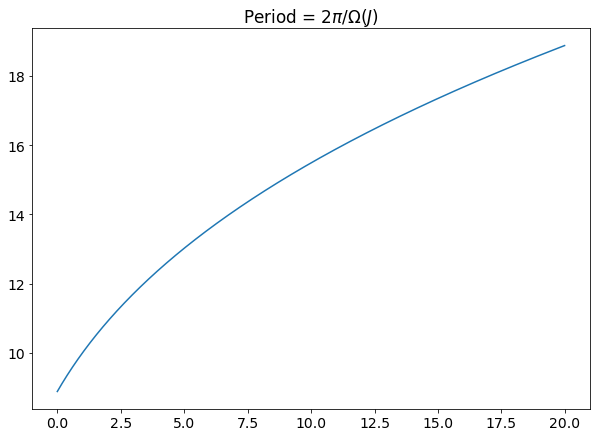

In [115]:
Js = np.arange(0, 20, 0.01)
periods = 2*np.pi / Omega(Js)

plt.plot(Js, periods)

plt.title(r"Period = $2\pi / \Omega(J)$")
plt.show()

## Vertical oscillation

Suppose a perturbation at time $t_i$ changes the distribution function $f$ by amplitude $f_0(J)$. Furthermore, for simplicity, only consider the perturbation's m=1 Fourier component in $\theta$. Then this perturbation evolves as:
$$f_0(J) \cos\left[\theta - \Omega(J)(t-t_i)-\theta_i\right] $$

In [ ]:
def delta_f_phase_mixing(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a perturbation
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

### 2D animations in matplotlib

Adapting my code from my "Phase Mixing Plots" notebook.

Sources for using FuncAnimation instead of ArtistAnimation:

https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

https://stackoverflow.com/questions/18274137/how-to-animate-text-in-matplotlib

## sanity check: plot $\delta f$ as $\Omega$ vs. $\theta$

In [ ]:
def delta_f_Omega_explicit(theta, Omega, t, A_0=1, t_i=0, theta_i=0):
    '''
    Same as delta_f, but we explicitly define Omega instead of 
    calculating it via J.
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

In [ ]:
# time range
tmin = 0
tmax = 10 # in Fig. 3, the time T-t_i goes to 100
tstep = 0.5
ts = np.arange(tmin, tmax, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
Omega_min = 0.
Omega_max = 0.7
step = 2e-2

thetas = np.arange(theta_min, theta_max, theta_max/50)
Omegas = np.arange(Omega_min, Omega_max, step)
thetas, Omegas = np.meshgrid(thetas, Omegas)

In [ ]:
## plot delta_f in Omega vs. theta space
fig, ax = plt.subplots(1,1,figsize=(10,10))

# initialize the color bar
Z = delta_f_Omega_explicit(thetas, Omegas, t=0)
im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
       extent=(theta_min, theta_max, Omega_min, Omega_max), animated=True, \
       aspect='auto') # automatically set plot's aspect ratio
fig.colorbar(im)

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\Omega$')

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    im.set_data([])
    return im

def updatefig(num):

    t = ts[num]
    Z = delta_f_Omega_explicit(thetas, Omegas, t)
    
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ## plot delta_f in Omega vs. theta phase space
    Z = Z[:-1, :-1]
    im.set_data(Z)
    
    ax.set_title('Gaia phase mixing (t=' + str(t) + ')')
    
    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("Gaia_phase_mixing_func_temp.mp4")

## plot $\delta f$ in angle-action coords

In [ ]:
## set bounds for t, theta, and J

# time range
tmin = 0
tmax = 100 # in Fig. 3, the time T-t_i goes to 100
tstep = 0.5
ts = np.arange(tmin, tmax, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
theta_step = theta_max/100

J_min = 1e-5
# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# we norm'd s.t. sigma*z_0=1. from eq. 7, J is roughly prop to v*z 
J_max = 10 
step = 1e-2

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.arange(J_min, J_max, step)
thetas, Js = np.meshgrid(thetas, Js)

# test that delta_f can take in a meshgrid
Z = delta_f(thetas, Js, 0.)

### define sqrt scale
Source: https://stackoverflow.com/questions/42277989/square-root-scale-using-matplotlib-python

In [ ]:
## define square root scale for y axis
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**0.5
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)**2
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()
 
mscale.register_scale(SquareRootScale)

In [ ]:
## phase mixing animation (J vs theta)
fig, ax = plt.subplots(1,1,figsize=(10,10))

# initialize the color bar
Z = delta_f_phase_mixing(thetas, Js, 0)
im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
                   extent=(theta_min, theta_max, J_min, J_max), animated=True, \
                   aspect='auto') # automatically set plot's aspect ratiofig.colorbar(im)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$J$")
## scale the J axis to be linear in sqrt(J)
ax.set_yscale('squareroot')
ax.set_yticks(np.arange(J_min, J_max, 1))
ax.set_yticks(np.arange(J_min, J_max, 0.5), minor=True)

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    im.set_data([])
    return im

start = time.time()
def updatefig(num):

    t = ts[num]
    if ((t % 5) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    Z = delta_f_phase_mixing(thetas, Js, t)
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ## plot delta_f in J vs. theta phase space
    Z = Z[:-1, :-1]
    im.set_data(Z)
    
    ax.set_title('Gaia phase mixing (t=' + str(t) + ')')
    
    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("Gaia_phase_mixing_func_temp.mp4")

In [ ]:
# density at theta=0
plt.plot(ts, delta_n_array[2:])

## Plotting $\delta f$ in polar coordinates

For now, I'll assume that vertical position $z$ corresponds to $\sqrt{J} \cos\theta$ and vertical velocity $v_z$ corresponds to $\sqrt{J} \sin\theta$. This isn't completely accurate because this assumes harmonic oscillations, while our system has an anharmonic oscillations. However, I'm making this assumption just so that I set up the code for integrating over $v_z$.

Python conversion between coordinates: https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates

Imshow in polar coordinates: https://stackoverflow.com/questions/54209640/imshow-in-polar-coordinates

Using set_array to (properly) update the data in the figure at each timestep: https://stackoverflow.com/questions/18797175/animation-with-pcolormesh-routine-in-matplotlib-how-do-i-initialize-the-data

And a very detailed animation example: http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

In [ ]:
## function for converting (thetas, Js) to (x_vals, y_vals)

def pol2cart_meshgrid(thetas, Js):
    '''
    Given a meshgrid of angles and actions (thetas, Js), return the 
    corresponding meshgrid in Cartesian coordinates.
    
    '''
    
    xs = np.sqrt(Js) * np.cos(thetas)
    ys = np.sqrt(Js) * np.sin(thetas)
    
    return xs, ys

In [ ]:
## phase mixing snail plot
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = delta_f(thetas, Js, 0)
# quad mesh
quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True)
fig.colorbar(quad1, ax=ax)

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    # global im
    t = ts[num]
    if ((t % 5) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    Z = delta_f(thetas, Js, t)
    Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('$\delta f$ (t=' + str(t) + ')')
    
    return quad1,


ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)

ani.save("Gaia_pm_polar_temp.mp4")

In [ ]:
## plotting the Gaia phase mixing snail at 1 timepoint
# plt.clf()
# fig, ax = plt.subplots(1,1,figsize=(12,10))

# # test that we can plot delta_f at a given t
# Z = delta_f(thetas, Js, 25.5)

# im = ax.pcolormesh(x_vals,y_vals,Z,cmap=cm.coolwarm, animated=True)

# fig.colorbar(im, ax=ax)

# ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
# ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")
# ax.set_title("$\delta f$")

# plt.show()

# Plotting the full second-order solution

In [ ]:
## definitions for Hamiltonian and f0 (and its derivatives)
def Hamiltonian(J, Omega_small=1/np.sqrt(2)):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    Also, we use Omega = a/(1 + b*J^{1/3}). I got the form of the 
    integral from Wolfram Alpha.
    
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small 
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a/b * J^{-1/3}
    b = a / Omega_big_coeff
    
    expr1 = b*J**(1/3) * (b*J**(1/3) - 2)
    expr2 = 2*np.log(b*J**(1/3) + 1)
    numerator = 3*a*(expr1 + expr2)
    denominator = 2 * b**3
    
    return numerator/denominator

def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper (ignoring the constant coefficient).
    
    '''
    
    return np.exp(-1*Hamiltonian(J))

def df0_dJ(J):
    '''
    The derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    We have df_0/dJ = -dH/dJ * exp(-H) = -Omega(J) * exp(-H).
    
    '''
    
    return -Omega(J) * np.exp(-1*Hamiltonian(J))

def f0_second_deriv(J):
    '''
    The second derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    By product rule, taking the derivative of df_0/dJ yields:
    
    -dOmega/dJ * exp(-H) + -Omega * [-dH/dJ * exp(-H)] = -dOmega/dJ * exp(-H) + (Omega^2)*exp(-H)
    = (-dOmega/dJ + Omega^2) * exp(-H)
    
    '''
        
    coeff = Omega(J)**2 - dOmega_dJ(J)
    
    return coeff * np.exp(-1*Hamiltonian(J))

In [52]:
def deltaf_over_f0(theta, J, t, t1, t2, n1, n2, A1, A2):
    '''
    Represents the relative distribution function delta_f / f0.
    
    '''
    
    return delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2) / f_0(J)

def f_full(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the full solution of the distribution function f; 
    i.e., f = f_0 + delta_f.
    
    '''
    
    return f_0(J) + delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the full solution to delta_f up to second order:
    
    delta_f = f^1 + epsilon*f^2 
    
    '''
    
    return delta_f_1(theta, J, t, t1, t2, n1, n2, A1, A2) + \
            delta_f_2(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_1(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the first-order solution for delta_f given two hammers:
    One with amplitude A1 at time t1, and one with amplitude A2 at time t2.
    
    '''
    
    expr1 = (-2) * n1 * A1 * df0_dJ(J) * np.sin(n1 * (theta - Omega(J)*(t-t1)))
    expr2 = (-2) * n2 * A2 * df0_dJ(J) * np.sin(n2 * (theta - Omega(J)*(t-t2)))
    
    # Heaviside coefficients on each expression
    if (t < t1):
        expr1 = 0
    if (t < t2):
        expr2 = 0
    
    return expr1 + expr2

def delta_f_2(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the first-order solution for delta_f given two hammers:
    One with amplitude A1 at time t1, and one with amplitude A2 at time t2.
    
    '''
    
    return delta_f_2_pm(theta, J, t, t1, t2, n1, n2, A1, A2) + \
                delta_f_2_echo(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_2_pm(theta, J, t, t1, t2, n1, n2, A1, A2,
                 dOmega_dJ_is_zero=False):
    '''
    Represents the phase-mixing (i.e., non-echo) component of the second-order solution for delta_f 
    given two hammers: One with amplitude A1 at time t1, and one with
    amplitude A2 at time t2.
    
    This formula assumes that A1 and A2 are constant; i.e., independent of J.
    
    '''
    
    # Heaviside function coefficient H(t-t_2), defined to be 0 at 0
    if (t < t2):
        return 0
    
    t_pm = (n1*t1 + n2*t2) / (n1 + n2)
    
    # function that contains the time evolution
    xi = (n1 + n2) * (theta - Omega(J)*(t - t_pm))
        
    expr1 = (-2)*A1*A2 * np.cos(xi) * n1*n2* f0_second_deriv(J)
    expr2 = (-2)*A1*A2 * np.sin(xi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    # assume that dOmega_dJ = 0
    if dOmega_dJ_is_zero:
        return expr1
    
    return expr1 + expr2
    

def delta_f_2_echo(theta, J, t, t1, t2, n1, n2, A1, A2,
                   dOmega_dJ_is_zero=False):
    '''
    Represents the echo component of the second-order solution for delta_f 
    given two hammers: One with amplitude A1 at time t1, and one with 
    amplitude A2 at time t2. See the last equations in Section 7.3 in my 
    senior thesis notes.
    
    This formula assumes that A1 and A2 are constant; i.e., independent of J.
    
    '''
    
    # Heaviside function coefficient H(t-t_2)
    if (t < t2):
        return 0
    
    t_echo = (n2*t2 - n1*t1) / (n2 - n1)
    
    # function that contains the time evolution
    psi = (n2 - n1) * (theta - Omega(J)*(t - t_echo))
        
    expr1 = 2*A1*A2 * np.cos(psi) * n1*n2* f0_second_deriv(J)
    expr2 = (-2)*A1*A2 * np.sin(psi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    # assume that dOmega_dJ = 0
    if dOmega_dJ_is_zero:
        return expr1
    
    return expr1 + expr2

The predicted echo time for the below parameters is:

$$\frac{n_2 t_2 - n_1 t_1}{n_2 - n_1} = \frac{3\cdot100 - 0}{2} = 150 $$

In [8]:
# hammer parameters (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

In [110]:
## t, theta, and J ranges + conversion to polar coords
# time range
tmin = t1
tmax = 300 # in Matt's animation, t goes to 35
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
# should split into four equally since we want data at theta = pi/2, pi, 3pi/2
num_thetas_sampled = 80
theta_step = theta_max/num_thetas_sampled

# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# we norm'd s.t. sigma*z_0=1. from eq. 7, J is roughly prop to v*z 
# here, we use different J steps for J<1 and J>1
J_min = 0
J_middle = 1
J_max = 20
J_step_small = 0.01
J_step_big = 0.1

Js_small = np.arange(J_min, J_middle, J_step_small)
Js_big = np.arange(J_middle, J_max, J_step_big)

# array that keeps track of the step sizes in J; used for integration of delta_n
J_steps_small = J_step_small*np.ones(len(Js_small))
J_steps_big = J_step_big*np.ones(len(Js_big))
J_steps = np.append(J_steps_small, J_steps_big)

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.append(Js_small, Js_big)
# thetas, Js are generated from a meshgrid 
thetas, Js = np.meshgrid(thetas, Js) # both thetas and Js has shape (# of Js, # of thetas)

x_vals, y_vals = pol2cart_meshgrid(thetas, Js)

Symmetric log for the color bar: https://matplotlib.org/stable/users/explain/colors/colormapnorms.html#symmetric-logarithmic

In [ ]:
## one snapshot of phase space 
Z = deltaf_over_f0(thetas, Js, 100, t1=t1, t2=t2, n1=n1, n2=n2, A1=A1, A2=A2)

fig, ax = plt.subplots(1, 1, figsize=(12,10))

im = ax.pcolormesh(thetas, Js, Z, 
                   #norm=colors.SymLogNorm(linthresh=1e-3, linscale=1,base=10),\
                       cmap=cm.coolwarm, shading='auto')
cbar = fig.colorbar(im, ax=ax)

ax.set_title('$\delta f \, / \, f_0$ (t=' + str(10) + ')')

plt.show()

In [ ]:
## full phase space density plotted in J/theta coords

fig, ax = plt.subplots(1,1,figsize=(12,10))

# initialize the color bar
Z = deltaf_over_f0(thetas, Js, 0, t1, t2, n1, n2, A1, A2)
quad1 = ax.pcolormesh(thetas, Js, Z, norm=colors.SymLogNorm(linthresh=1e-3, linscale=1,\
                        base=10),\
                       cmap=cm.coolwarm, shading='auto')
fig.colorbar(quad1, ax=ax, extend='both')

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$J$")

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    quad1.set_array([])
    return quad1

start = time.time()
def updatefig(num):
    
    t = ts[num]
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    Z = deltaf_over_f0(thetas, Js, t, t1, t2, n1, n2, A1, A2)
    
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ## plot delta_f in J vs. theta phase space
    #Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('$\delta f \, / \, f_0$ (t=' + str(t) + ')')

    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("two_hammers_temp.mp4")

In [ ]:
# density at theta=0
plt.plot(ts, delta_n_array[2:])
plt.title(r'$\delta n$ at $\theta = 0$')
plt.savefig('two_hammers_delta_n_cartesian.png')
plt.show()


In [ ]:
# t after t2 where delta_n peaks 
# (the +2 offset is needed because delta_n_array has 2 extra terms at the start, idk why)
second_hammer_t = (int) (t2 / tstep)
print("$\delta n$ peaks at this t:")
print(ts[np.argmax(np.abs(delta_n_array[(second_hammer_t+2):]))]+t2)

## full $f$ in polar coords

<ipython-input-102-cd9772b05bc2>:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad1 = ax.pcolormesh(x_vals,y_vals,Z, \


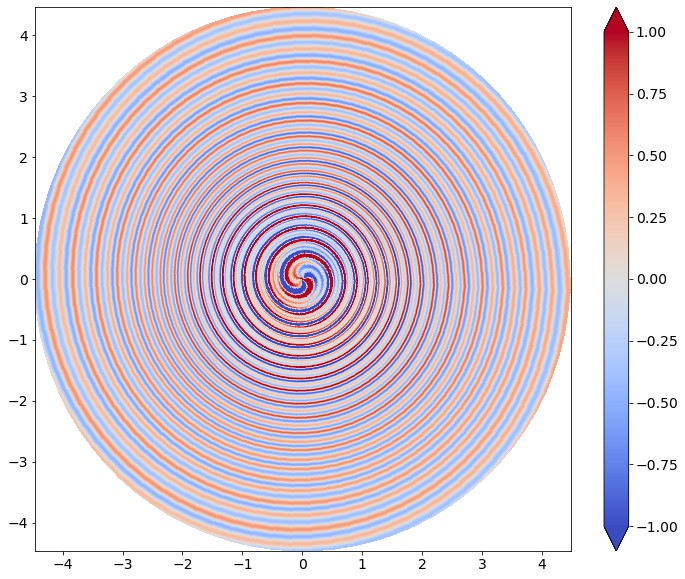

In [102]:
# one snapshot of quad mesh
Z = deltaf_over_f0(thetas, Js, 280, t1=t1, t2=t2, n1=n1, n2=n2, A1=A1, A2=A2)

fig, ax = plt.subplots(1, 1, figsize=(12,10))

quad1 = ax.pcolormesh(x_vals,y_vals,Z, \
                      #norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-6,base=10),\
                       cmap=cm.coolwarm, shading='auto', 
                     vmin=-1, vmax=1)
fig.colorbar(quad1, ax=ax, extend='both')

plt.show()

<ipython-input-103-46fe3e9bd0bf>:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad1 = ax.pcolormesh(x_vals,y_vals,Z,


t = 0.0
Elapsed t: 0.6 seconds
t = 0.0
Elapsed t: 0.8 seconds
t = 0.0
Elapsed t: 0.9 seconds
t = 20.0
Elapsed t: 32.2 seconds


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x720', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'two_hammers_polar_temp.mp4']' returned non-zero exit status 255.

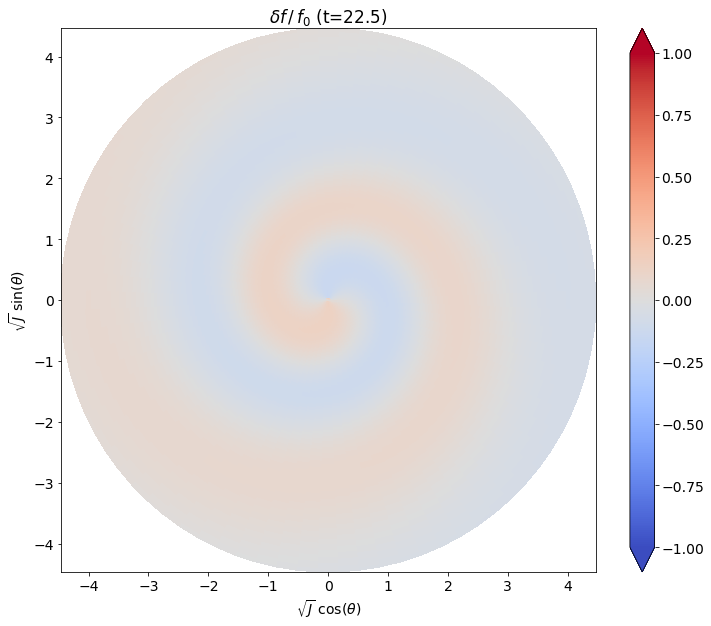

In [103]:
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = deltaf_over_f0(thetas, Js, 0, t1, t2, n1, n2, A1, A2)
# quad mesh
quad1 = ax.pcolormesh(x_vals,y_vals,Z,
                      #norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-6,base=10),\
                       cmap=cm.coolwarm, shading='auto',
                      vmin=-1, vmax=1)
fig.colorbar(quad1, ax=ax, extend='both')

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

# the overdensity at x=0 as a function of time
delta_n_array = []

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    t = ts[num]
    if ((t % 20) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

     
    Z = deltaf_over_f0(thetas, Js, t, t1, t2, n1, n2, A1, A2)
    quad1.set_array(Z.ravel())
    
    # integrate over Z at x_val=0, ie, at theta = +-pi/2
    theta_ind = (int) (num_thetas_sampled / 4) # index of theta = pi/2
    
    # TODO: write code to integrate over arbitrary x, including
    # way to calculate arbitrary step size dy
    delta_n = np.sum(Z[:, theta_ind]) # integrate over "y" at theta=pi/2
    ...
    
    delta_n += np.sum(Z[:, num_thetas_sampled-theta_ind]) # theta=-pi/2
    delta_n_array.append(delta_n)
    
    ax.set_title('$\delta f \, / \, f_0$ (t=' + str(t) + ')')
    
    return quad1,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)

ani.save("two_hammers_polar_temp.mp4")

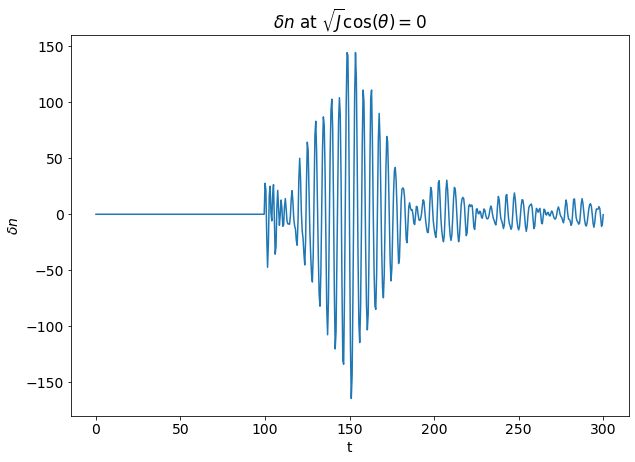

In [84]:
# density at x_val=0
plt.plot(ts, delta_n_array[2:])
plt.title(r'$\delta n$ at $\sqrt{J} \cos(\theta) = 0$')

plt.xlabel('t')
plt.ylabel(r'$\delta n$')

plt.savefig('two_hammers_deltan_polar_temp.png')
plt.show()

In [85]:
delta_n_array[:10]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.440892098500626e-15,
 3.552713678800501e-15,
 3.552713678800501e-15]

In [87]:
# t after t2 where delta_n peaks 
# (the +2 offset is needed because delta_n_array has 2 extra terms at the start, idk why)
second_hammer_t = (int) (t2 / tstep)
print("delta n peaks at this t:")
ts[np.argmax(np.abs(delta_n_array[(second_hammer_t+2):]))]+t2

delta n peaks at this t:


151.0